In [1]:
import networkx as nx
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from scipy.spatial.distance import cdist

from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

import craterdetection.common.constants as const
from craterdetection.common.camera import Camera
from craterdetection.common.coordinates import nadir_attitude
from craterdetection.matching.database import extract_robbins_dataset, load_craters, CraterDatabase
from craterdetection.matching.projective_invariants import crater_representation, CoplanarInvariants, scale_det
from craterdetection.matching.utils import cyclic_permutations, enhanced_pattern_shifting, is_clockwise, all_clockwise, \
    np_swap_columns, is_colinear, cw_or_ccw, get_cliques_by_length
from craterdetection.common.conics import *



In [2]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 10], ellipse_limit=1.1)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [3]:
# Camera parameters can be derived from RNG
cam_lat, cam_long = map(np.radians, (45., 45.))
cam_alt = 250

cam = Camera.from_coordinates(cam_lat, cam_long, cam_alt, resolution=(256, 256))

cam.T = (Rotation.from_matrix(cam.T) * Rotation.from_euler('x', 25, degrees=True)).as_matrix()

dist = cam_alt / np.cos(np.radians(cam.fov/2)*np.sqrt(2)*1.0)
vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
r_craters = r_craters_cat[vicinity]
C_craters = C_craters_cat[vicinity]
A_craters = cam.project_crater_conics(C_craters, r_craters)

crater_centers = cam.project_crater_centers(r_craters)

C:\dev\workspace\crater-detection\craterdetection\common\conics.py:150: UserWarning: No contour levels were found within the data range.
  ax.contour(x_plot, y_plot, c.reshape(x_plot.shape), [0], colors=rim_color)


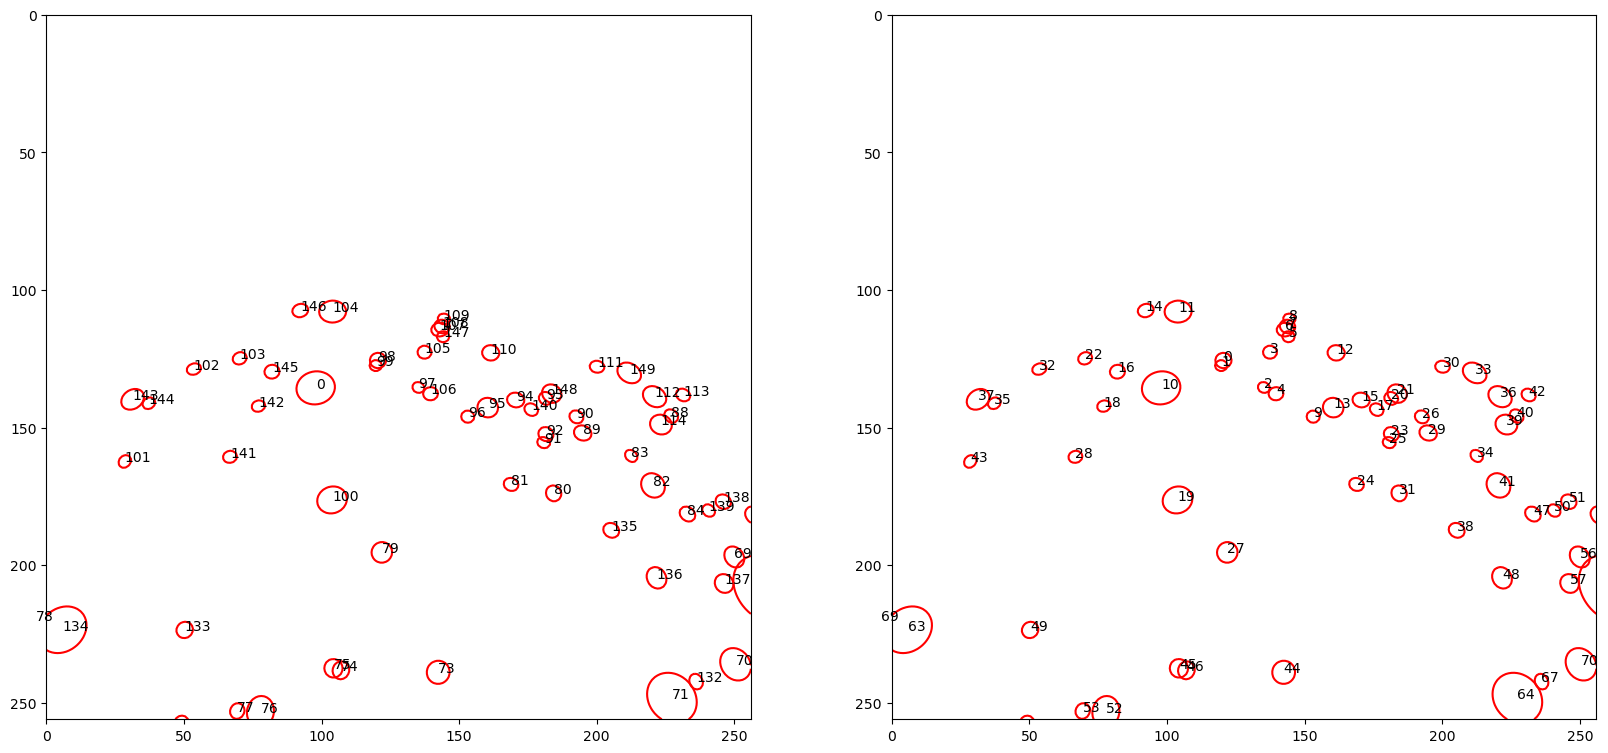

In [4]:
plt.style.use('default')

fig, axes = plt.subplots(1, 2, figsize=(20, 40), subplot_kw={'aspect': 'equal'})

plot_conics(A_craters, resolution=cam.resolution, plot_centers=True, ax=axes[0])
detection_order = np.argsort(cdist(crater_centers, np.array(cam.resolution)[None, :]/2).squeeze())

plot_conics(A_craters[detection_order], resolution=cam.resolution, plot_centers=True, ax=axes[1])

In [5]:
%%time
detection_graph = nx.minimum_spanning_tree(nx.from_numpy_matrix(cdist(crater_centers, crater_centers)))

Wall time: 53 ms


In [6]:
db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 10], latlims=[30, 60], longlims=[30, 60], radius=100)
# db = CraterDatabase(lat_cat[vicinity], long_cat[vicinity], major_cat[vicinity], minor_cat[vicinity], psi_cat[vicinity], radius=500)

In [7]:
np.set_printoptions(precision=3)
max_diff = 0.02
correct_matches = {detection_key : [] for detection_key, _ in enumerate(A_craters[detection_order])}
max_iter = 1e2

for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters[detection_order])):
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)

        diff = np.mean(np.abs(((db.features - features[order_full])/features[order_full])), axis=1)

        if np.min(diff) < max_diff:
            min_idx = np.argwhere(diff <= max_diff)

            subset_match = np.logical_and.reduce(lat_cat[vicinity][detection_order][crater_triad[order]] \
                                                                             == db.get_position(min_idx)[0].T, axis=2)
            if np.logical_or.reduce(subset_match):
                print(f"MATCH [{i}]")
                match = min_idx[np.where(subset_match)].item()
                print(crater_triad)
                print(order_full)

                rank = np.where(np.sort(diff) == diff[match])[0].item()
                print(f"\tMean difference: {diff[match]:.2%}, position: "
                      f"{rank}")

                print("\tDetection feature: \t", features[order_full])
                print("\tDB match feature: \t", db.features[match])

                print("\tCrater triad coords: \t",
                      lat_cat[vicinity][detection_order][crater_triad[order]],
                      long_cat[vicinity][detection_order][crater_triad[order]])
                print("\tDB match coords: \t", *db.get_position(match))
                for detection_idx, db_idx in zip(crater_triad[order], db.crater_triads[match]):
                    correct_matches[detection_idx] += [db_idx]
                print()
                break

    if i >= max_iter:
        break


MATCH [0]
[0 1 2]
[ 2  0  1  5  3  4 -1]
	Mean difference: 0.06%, position: 0
	Detection feature: 	 [ -52.542    2.469  -54.802  -37.342    2.389  -59.023 -181.781]
	DB match feature: 	 [ -52.497    2.469  -54.834  -37.374    2.389  -58.972 -181.909]
	Crater triad coords: 	 [0.849 0.855 0.854] [0.791 0.779 0.779]
	DB match coords: 	 [0.849 0.855 0.854] [0.791 0.779 0.779]

MATCH [1]
[3 4 5]
[ 0  1  2  3  4  5 -1]
	Mean difference: 0.16%, position: 0
	Detection feature: 	 [ -37.982  -79.121  -11.873  -34.834  -90.732  -10.433 -277.334]
	DB match feature: 	 [ -38.045  -78.917  -11.882  -34.77   -90.948  -10.425 -277.645]
	Crater triad coords: 	 [0.857 0.848 0.86 ] [0.793 0.794 0.799]
	DB match coords: 	 [0.857 0.848 0.86 ] [0.793 0.794 0.799]

MATCH [2]
[6 7 8]
[ 0  1  2  3  4  5 -1]
	Mean difference: 0.20%, position: 0
	Detection feature: 	 [ 2.743  1.577 -0.435  2.756  1.323  0.178  2.856]
	DB match feature: 	 [ 2.743  1.578 -0.438  2.756  1.322  0.179  2.858]
	Crater triad coords: 	 [

In [8]:
np.set_printoptions(precision=3)
max_diff = 0.02
correct_matches = {detection_key : [] for detection_key, _ in enumerate(A_craters[detection_order])}
max_iter = 1e3

for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters[detection_order])):
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)

        diff = np.mean(np.abs(((db.features - features[order_full])/features[order_full])), axis=1)

        if np.min(diff) < max_diff:
            min_idx = np.argmin(diff)

            for detection_idx, db_idx in zip(crater_triad[order], db.crater_triads[min_idx]):
                correct_matches[detection_idx] += [db_idx]
            break

    if i >= max_iter:
        break

In [10]:
for k, v in correct_matches.items():
    print(k, v)

0 [781, 781, 781, 781, 781, 781, 781]
1 [782, 782, 782, 782, 782, 782, 782, 782, 782, 782, 782, 782, 782, 782]
2 [780, 780, 780, 780, 780, 780, 780, 780, 780, 780, 780, 780, 780, 780, 780]
3 [811, 811, 811, 811, 811, 811, 811, 811, 811, 811, 811, 811, 811, 811, 811, 811]
4 [812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812]
5 [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]
6 [813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813]
7 [814, 814, 814, 814, 814, 814, 814, 814, 814, 814, 814, 814, 814, 814, 814, 814, 814, 814, 814, 814]
8 [815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815]
9 [779, 779, 779, 779, 779, 779, 779, 779, 779, 779, 779, 779, 779, 779, 779, 779, 779, 779, 779, 779, 779]
10 [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
11 [810, 810, 810, 810, 